# **RNN Tutorial: Predicting Strain from Stress and Volume Fraction**

## **Introduction**

Recurrent Neural Networks (RNNs) are designed to handle sequential data by maintaining memory of previous inputs. In this tutorial, we apply an RNN to predict strain from stress and volume fraction in a material, treating each stress–strain curve as a sequence.

---

## **Problem Statement**

We are given a dataset containing:

- **Volume Fraction (%):** Material composition parameter  
- **Stress (MPa):** Applied mechanical force  
- **Strain:** Material deformation (target to predict)

For each volume fraction, we observe a stress–strain curve, which we treat as a time-like sequence. Our objectives are:

1. **Train an RNN** to predict strain from sequential stress and volume fraction data.
2. **Visualize predicted vs. true stress–strain curves** for each volume fraction.
3. **Evaluate performance** using R² score, MAE, and MSE.
4. **Compare with a Feedforward Neural Network (FFNN)** to see the benefit of sequence learning.

In [1]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Step 01: Import Libraries and Set Up Device**



In [2]:
# Import essential libraries
import pandas as pd                        # For data handling (CSV, DataFrame)
import torch                               # Core PyTorch library
import torch.nn as nn                      # Neural network modules (layers, activations, etc.)
from torch.utils.data import Dataset, DataLoader  # Tools for handling datasets and batching
from sklearn.preprocessing import MinMaxScaler    # For feature normalization (scaling 0–1)
import matplotlib.pyplot as plt            # For plotting and visualization
import numpy as np                         # For numerical operations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Evaluation metrics

# Set up the device (use GPU if available, otherwise fallback to CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **Step 02: Load and Preprocess the Stress–Strain Dataset**

In this step, we load the CSV file containing experimental stress–strain data for different volume fractions. We sort the data to preserve the sequence within each volume fraction, normalize the inputs and outputs using MinMaxScaler, and create scaled versions of each column to use in model training.

In [5]:
# Load the cleaned dataset
df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/RNN/compiled_stress_strain.csv")

# Sort the data so each volume fraction's stress–strain curve is sequential
df = df.sort_values(by=["Volume_Fraction", "Stress"])

# Separate the input features (Volume Fraction, Stress) and target output (Strain)
X_raw = df[['Volume_Fraction', 'Stress']].values  # Input features
y_raw = df[['Strain']].values                     # Target strain

# Initialize scalers for input and output normalization
scaler_x = MinMaxScaler()   # For Volume Fraction and Stress
scaler_y = MinMaxScaler()   # For Strain

# Normalize the input and output to range [0, 1]
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# Store normalized columns in the original DataFrame for easy access
df['X1'] = X_scaled[:, 0]       # Scaled Volume Fraction
df['X2'] = X_scaled[:, 1]       # Scaled Stress
df['y_scaled'] = y_scaled[:, 0] # Scaled Strain

## **Visualize True Stress–Strain Curves by Volume Fraction**

Before training our RNN, it's important to understand the structure of the data. Each volume fraction corresponds to a unique stress–strain curve. In this step, we plot the actual (true) stress–strain curves for each volume fraction to observe their behavior.

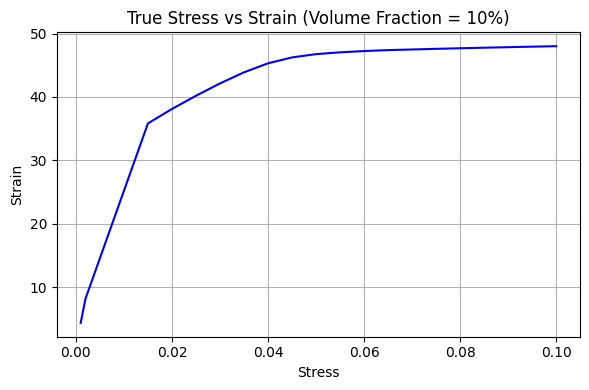

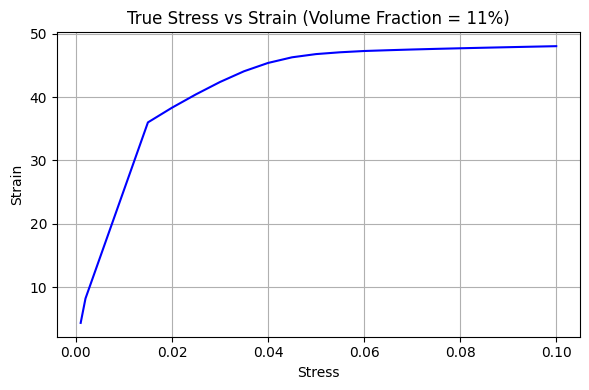

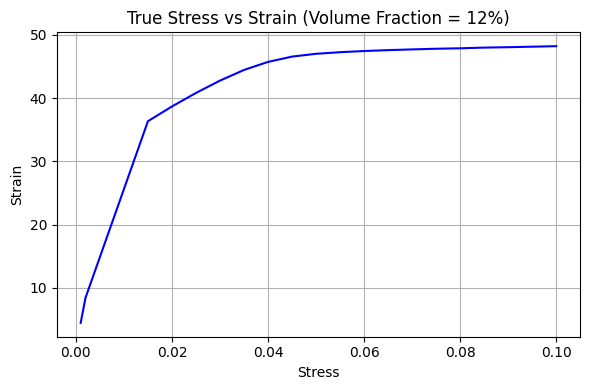

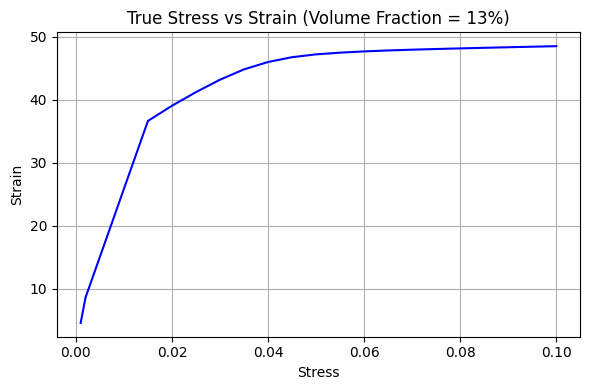

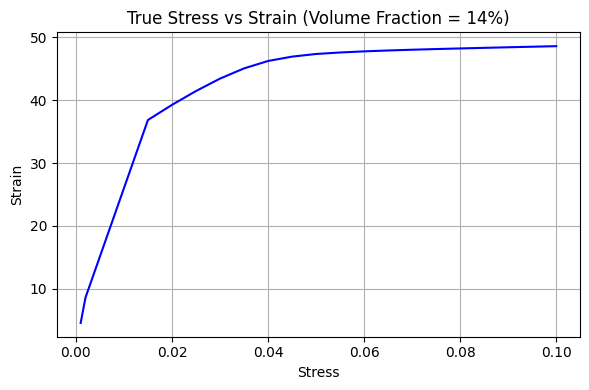

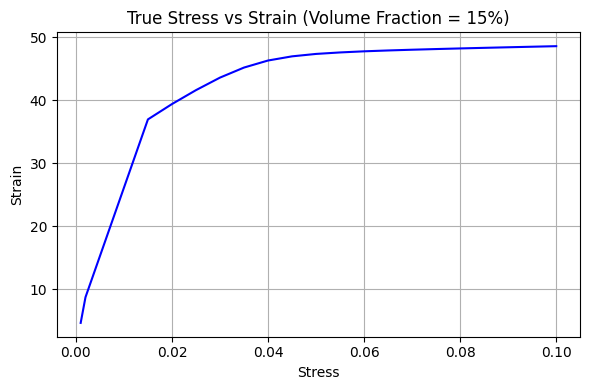

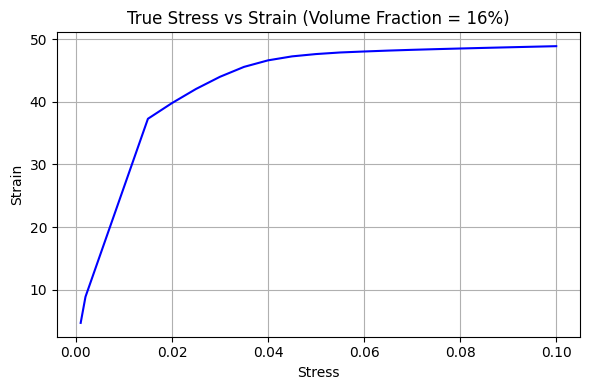

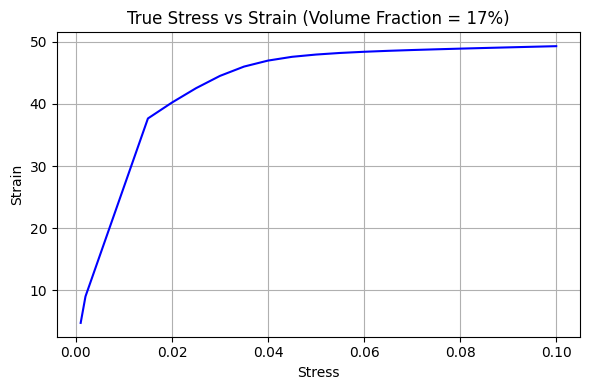

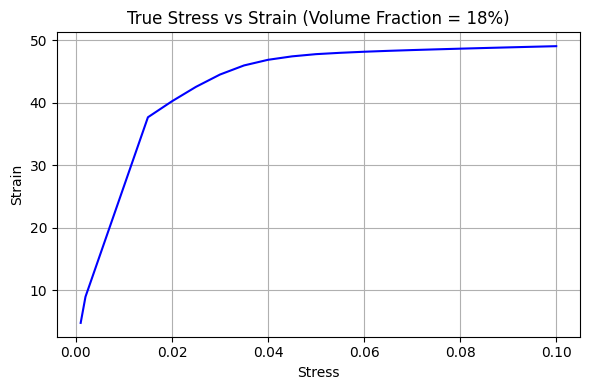

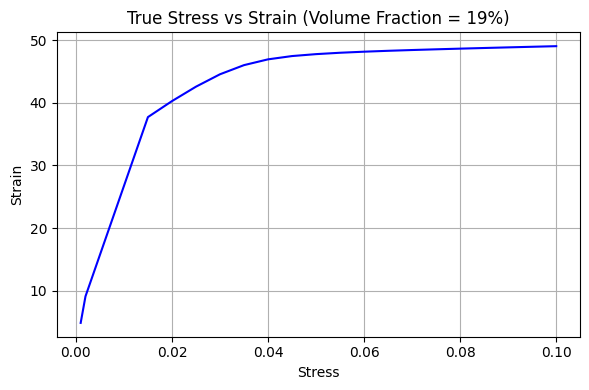

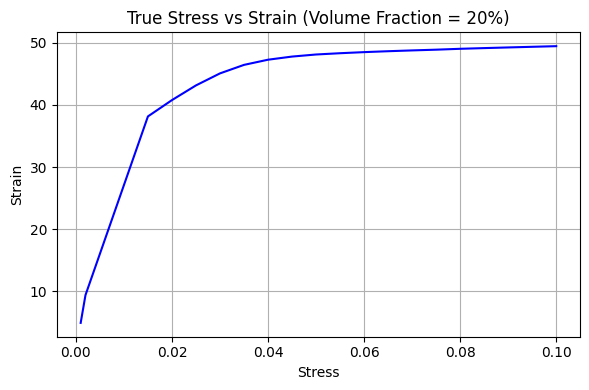

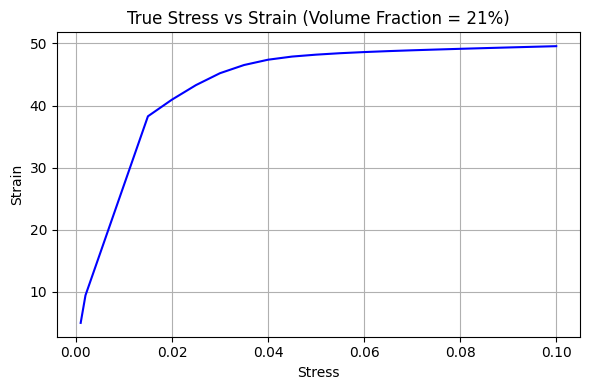

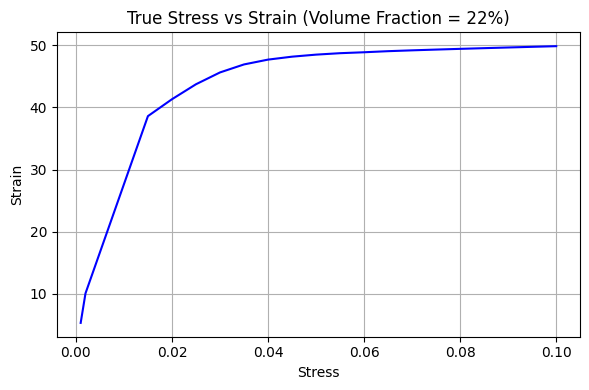

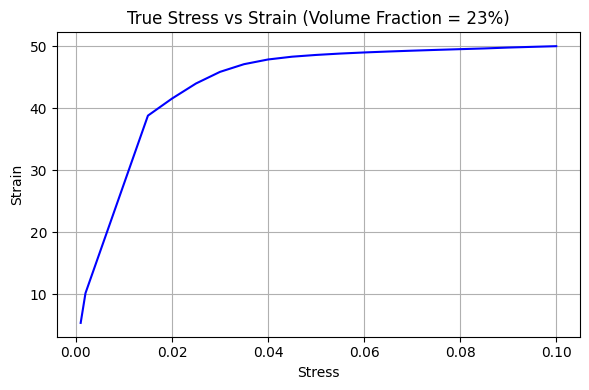

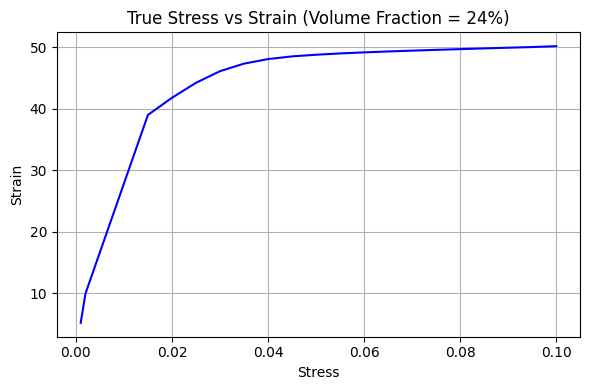

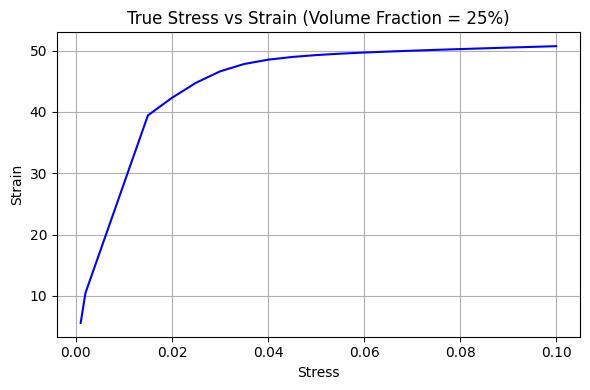

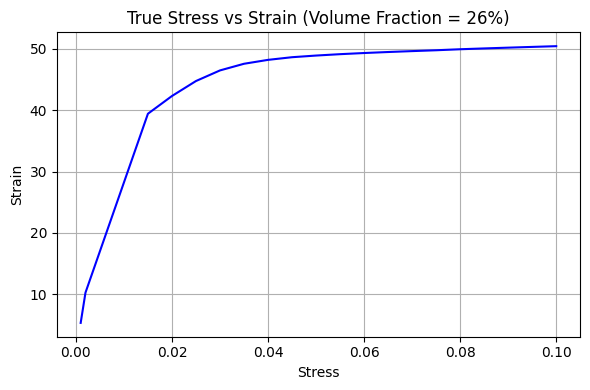

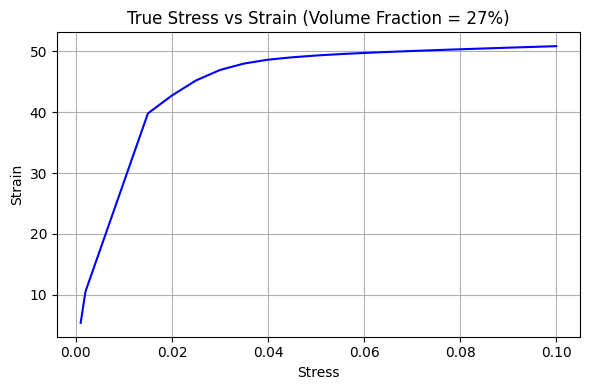

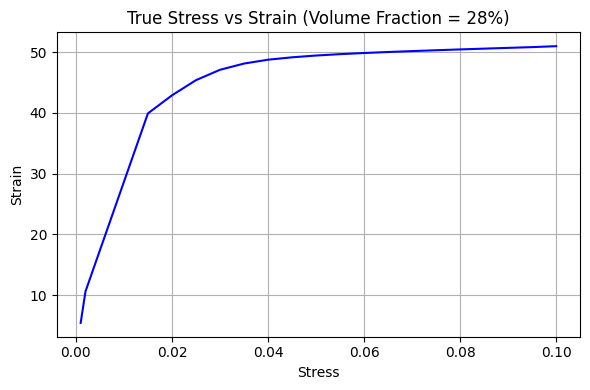

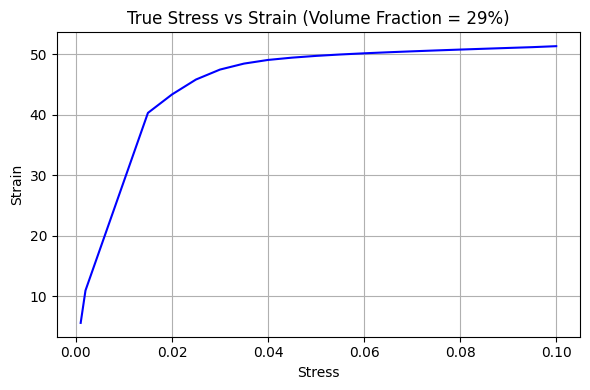

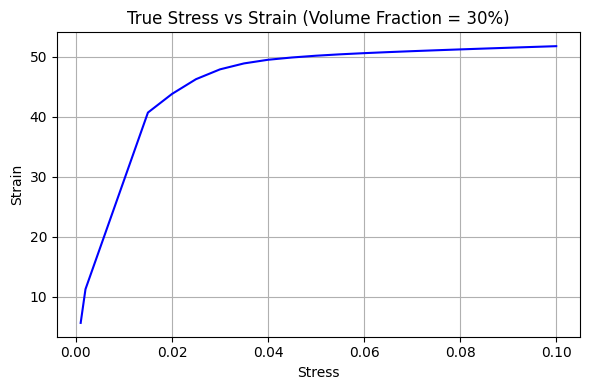

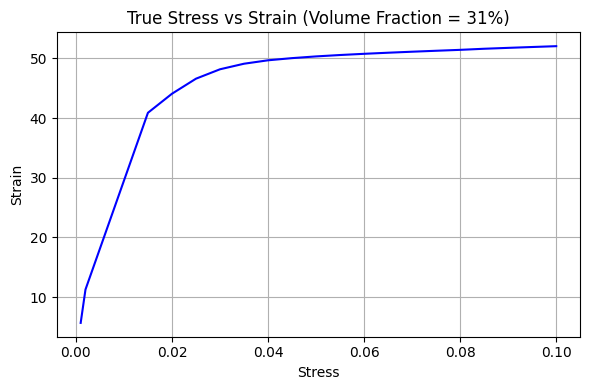

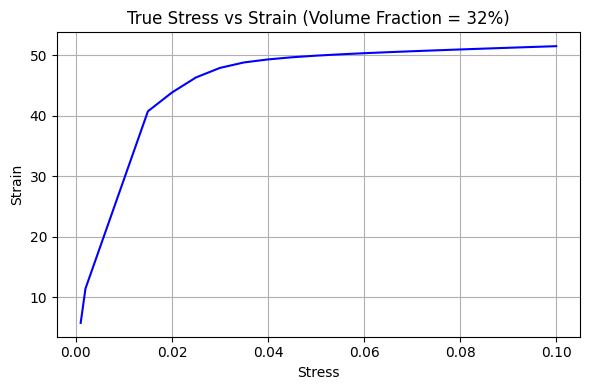

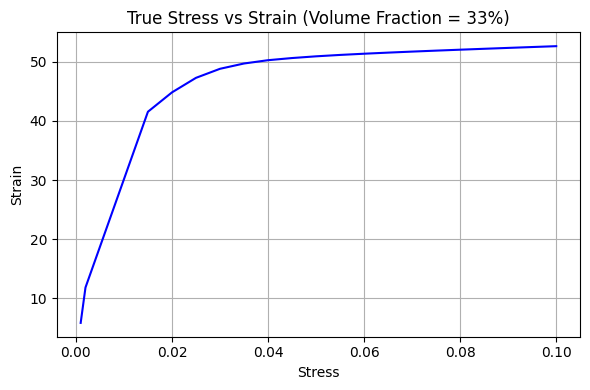

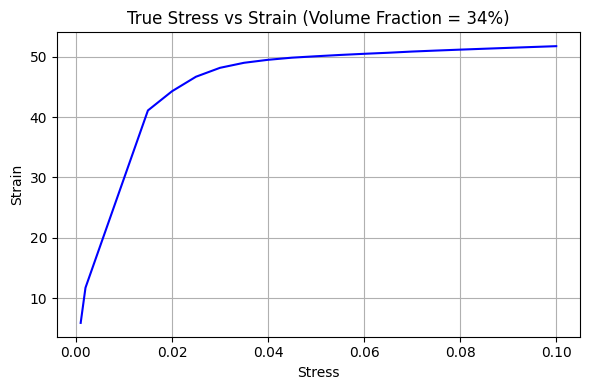

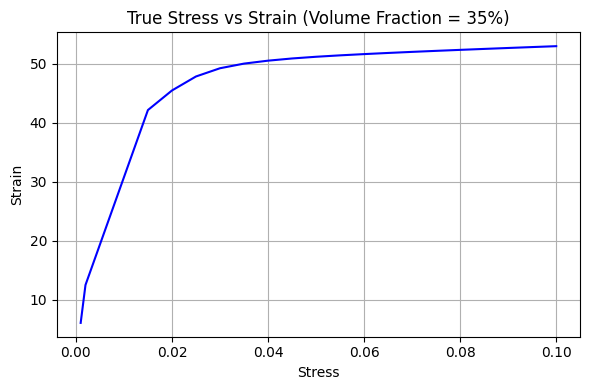

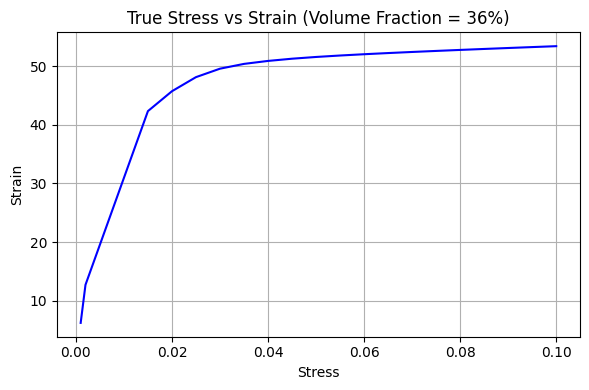

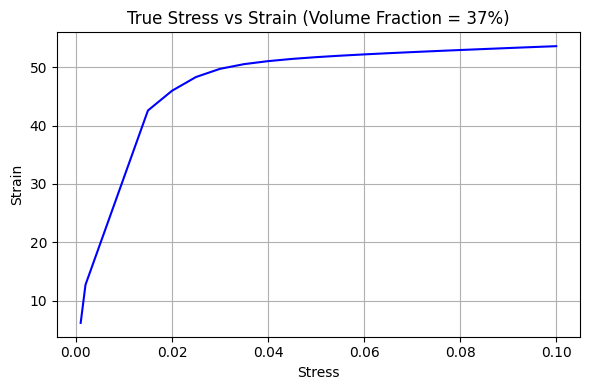

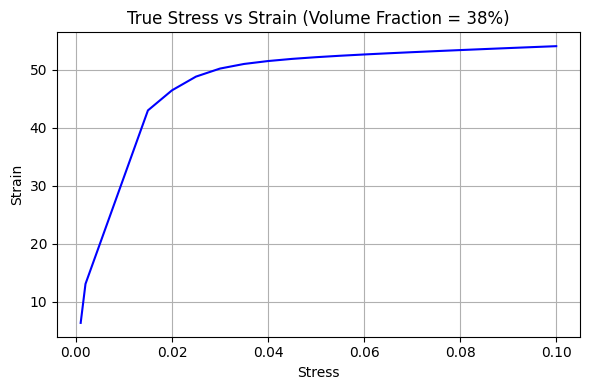

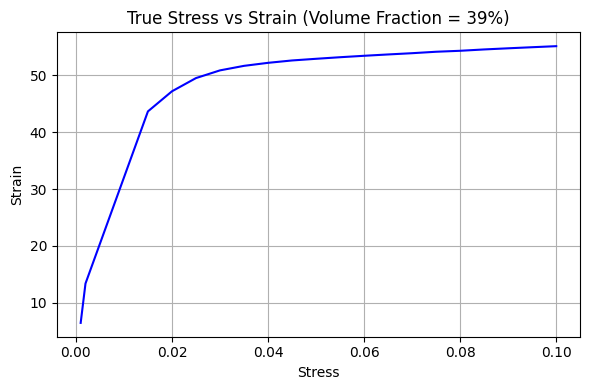

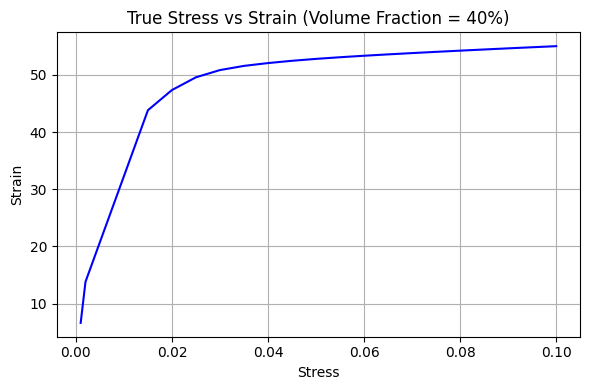

In [6]:
# Get all unique volume fractions
unique_vf = sorted(df['Volume_Fraction'].unique())

# Plot the true stress–strain curve for each volume fraction
for vf in unique_vf:
    # Filter the DataFrame for the current volume fraction
    group = df[df['Volume_Fraction'] == vf]

    # Extract stress and strain values
    stress = group['Stress'].values
    strain = group['Strain'].values

    # Create the plot
    plt.figure(figsize=(6, 4))
    plt.plot(stress, strain, label='True Curve', color='blue')
    plt.xlabel("Stress")
    plt.ylabel("Strain")
    plt.title(f"True Stress vs Strain (Volume Fraction = {vf}%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **Step 03: Define the RNN Model for Strain Prediction**

In this step, we define a Recurrent Neural Network (RNN) model using PyTorch. The model takes in a sequence of input features — volume fraction and stress — and learns to predict the corresponding strain values.

- The RNN layer processes the sequence of inputs and captures temporal dependencies across the stress–strain curve.
- The output layer maps the RNN’s hidden state at each step to a single predicted strain value.

In [7]:
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()

        # RNN layer
        # input_size = 2 because we have 2 features: volume_fraction and stress
        # hidden_size = 32 (number of neurons)
        self.rnn_layer = nn.RNN(
            input_size=2,
            hidden_size=32,
            batch_first=True  # ensures input shape is [batch, sequence, features]
        )

        # Output layer
        # Takes the hidden output from RNN and converts to 1 output: strain
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x, hidden_state=None):
        """
        x: input tensor of shape [batch_size, sequence_length, input_features]
        hidden_state: optional initial hidden state for the RNN

        Returns:
            output: predicted strain values
            hidden_state: final hidden state (useful if continuing sequence)
        """
        rnn_output, hidden_state = self.rnn_layer(x, hidden_state)
        predicted_strain = self.output_layer(rnn_output)  # [batch, seq_len, 1]
        return predicted_strain, hidden_state

## **Step 04: Train the RNN Model**

In this step, we train the RNN to learn the mapping between input sequences — volume fraction and stress — and the corresponding output sequence of strain values. Each volume fraction group is treated as an independent sequence.

We use:
- **Mean Squared Error (MSE)** loss for regression
- **Adam optimizer** for fast and adaptive training
- 100 epochs of training with detailed loss tracking

In [8]:
# Initialize the model and move it to the selected device (CPU or GPU)
model = RNNModel().to(device)

# Define the loss function: Mean Squared Error (used for regression tasks like strain prediction)
criterion = nn.MSELoss()

# Use Adam optimizer — a widely used, adaptive optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the model in training mode
model.train()
print("Starting RNN training...\n")

# Empty list to store average loss per epoch
loss_history = []

# Training loop for a fixed number of epochs
for epoch in range(100):
    total_loss = 0.0

    # Train using each volume fraction group as a sequence
    for vf in sorted(df['Volume_Fraction'].unique()):
        group = df[df['Volume_Fraction'] == vf]

        if len(group) < 2:
            continue

        # Prepare inputs and targets
        input_features = group[['X1', 'X2']].values
        target_strain = group[['y_scaled']].values

        input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0).to(device)
        target_tensor = torch.tensor(target_strain, dtype=torch.float32).unsqueeze(0).to(device)

        # Forward pass
        predicted, _ = model(input_tensor)
        loss = criterion(predicted, target_tensor)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Save average loss of this epoch
    avg_loss = total_loss / len(df['Volume_Fraction'].unique())
    loss_history.append(avg_loss)

    # Print every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Average Loss: {avg_loss:.6f}")

print("\nTraining complete!")


Starting RNN training...

Epoch 000 | Average Loss: 0.291014
Epoch 010 | Average Loss: 0.001597
Epoch 020 | Average Loss: 0.000374
Epoch 030 | Average Loss: 0.000458
Epoch 040 | Average Loss: 0.000599
Epoch 050 | Average Loss: 0.000620
Epoch 060 | Average Loss: 0.000605
Epoch 070 | Average Loss: 0.000586
Epoch 080 | Average Loss: 0.000567
Epoch 090 | Average Loss: 0.000548

Training complete!


## **Visualize Training Loss**

After training, we plot the average MSE loss per epoch to evaluate how well the model is learning. A decreasing loss curve usually indicates successful learning.

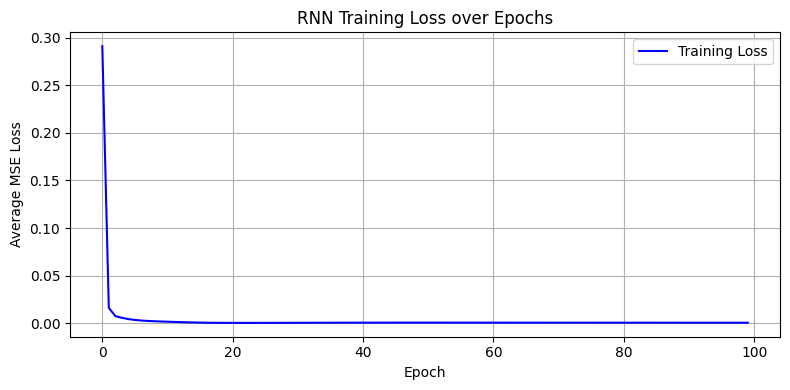

In [9]:
# 📉 Plot training loss over epochs
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Average MSE Loss")
plt.title("RNN Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Step 05: Visualize Predicted vs. True Stress–Strain Curves**

Now that the RNN has been trained, we evaluate how well it predicts strain from input features (volume fraction and stress).

For each volume fraction:
- We pass the full stress–strain sequence through the model
- We plot both the true strain values and the predicted ones
- This helps visually assess the model's accuracy for each material configuration

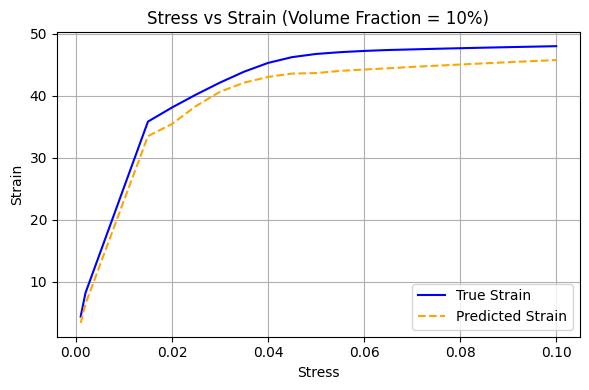

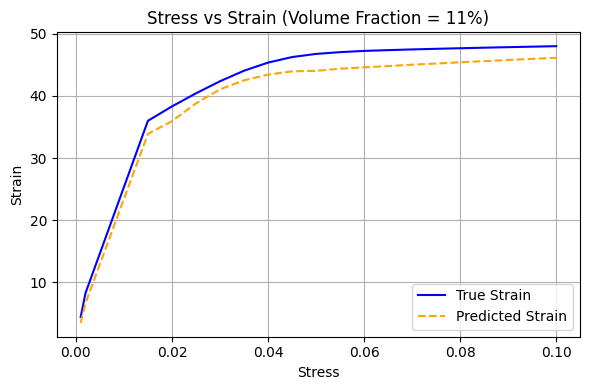

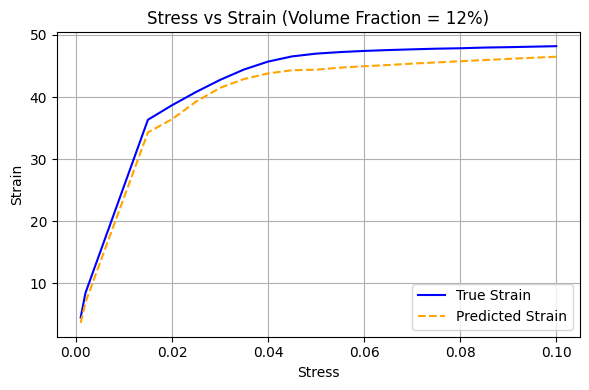

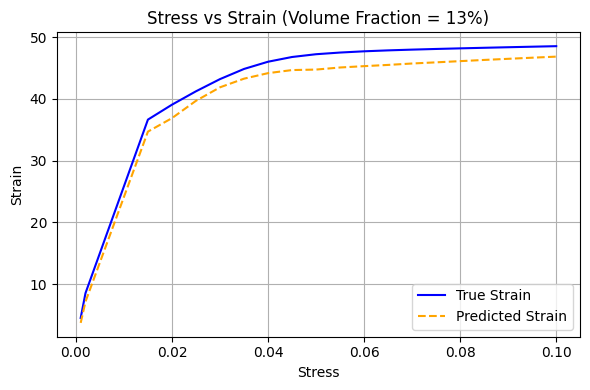

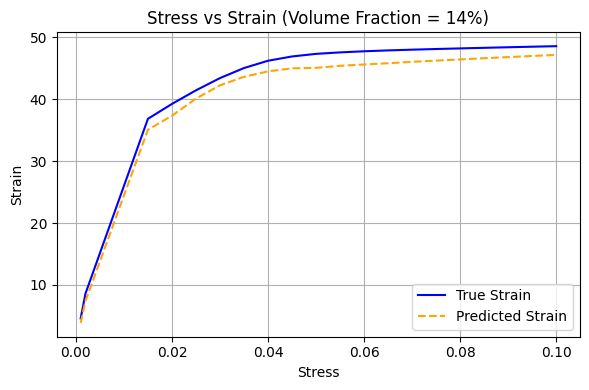

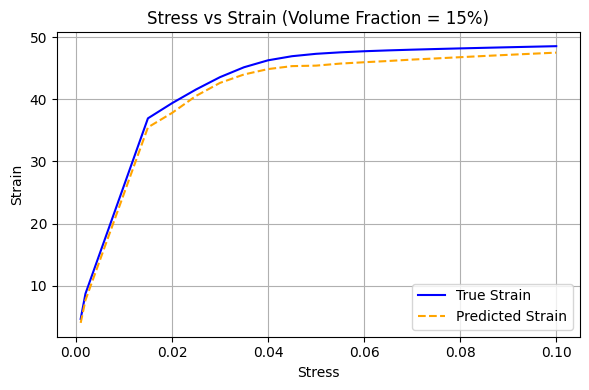

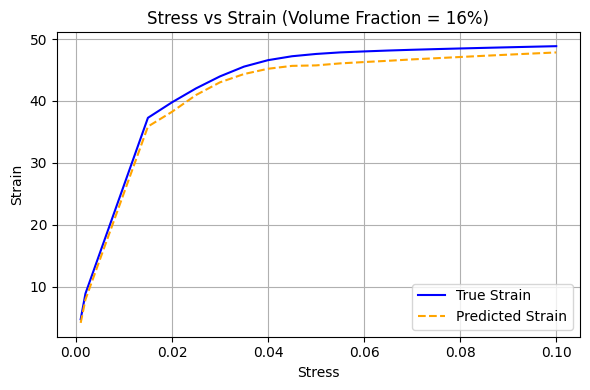

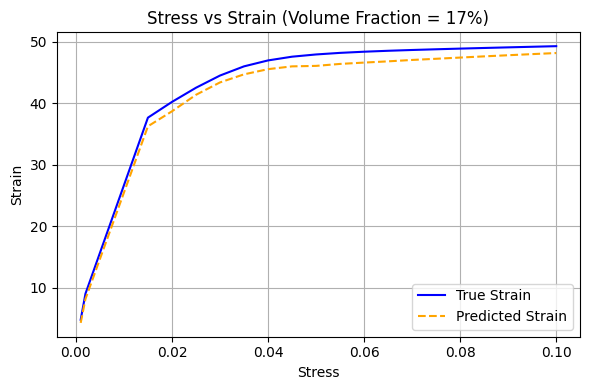

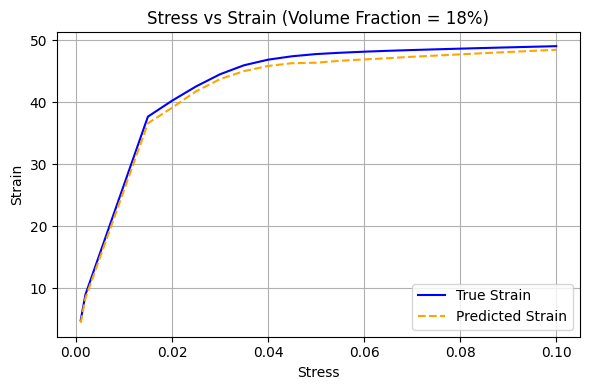

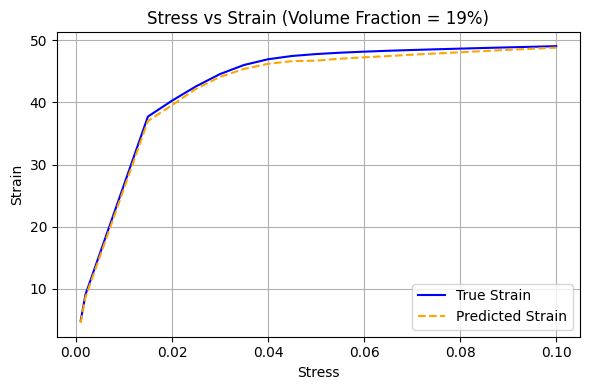

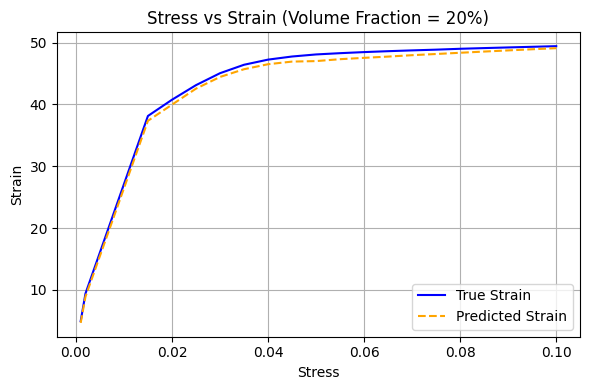

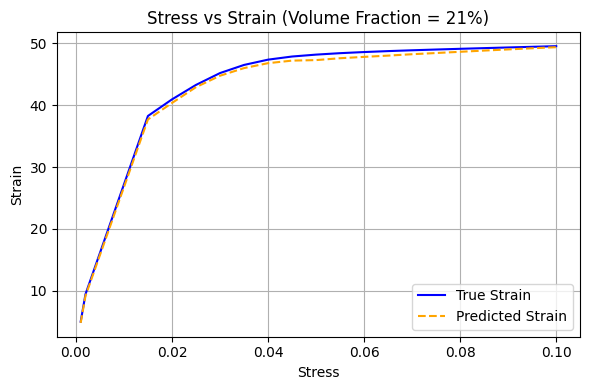

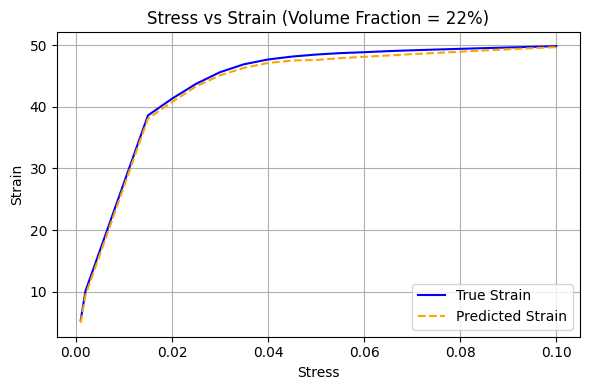

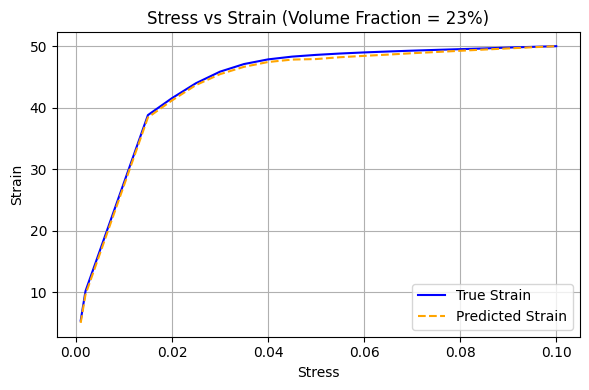

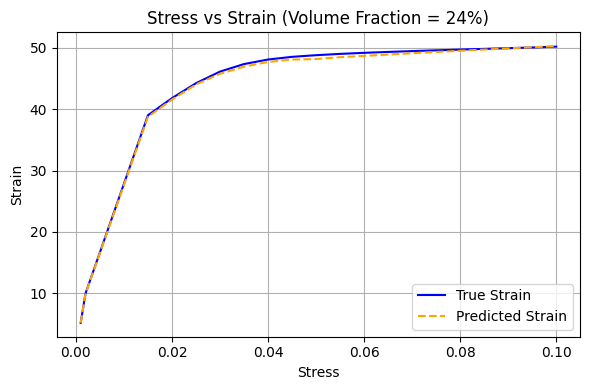

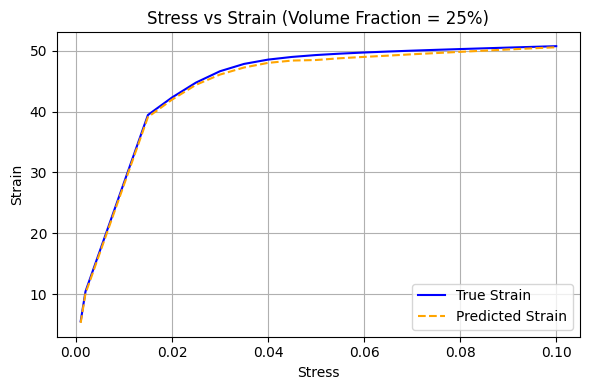

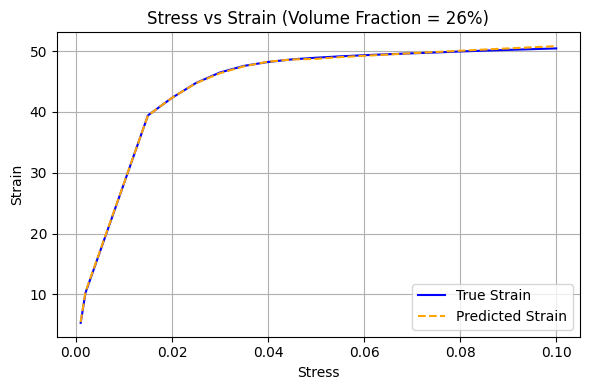

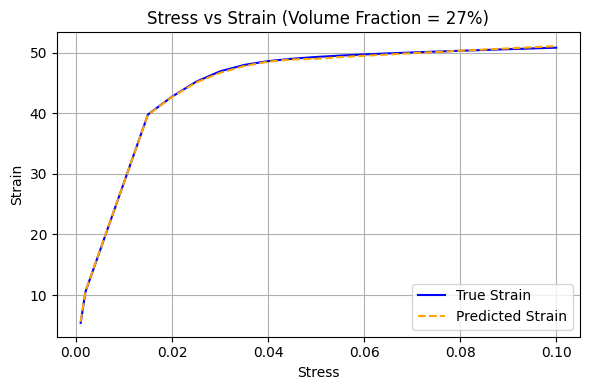

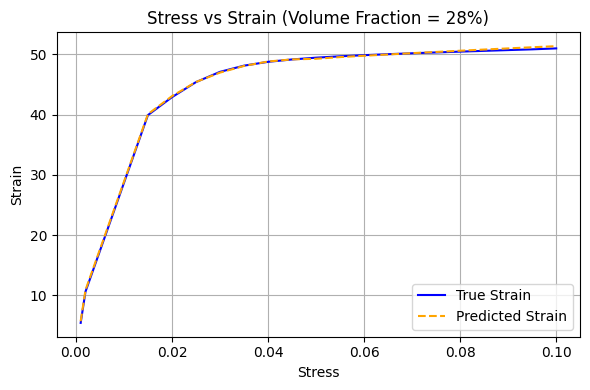

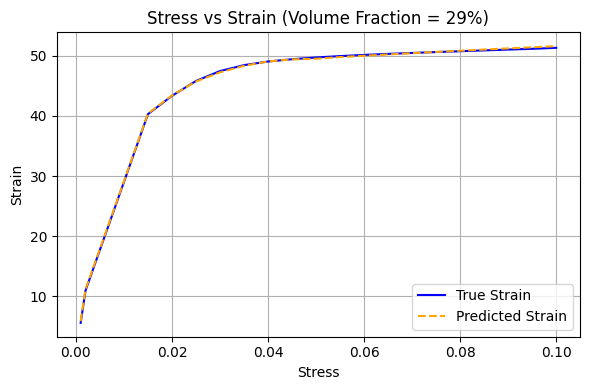

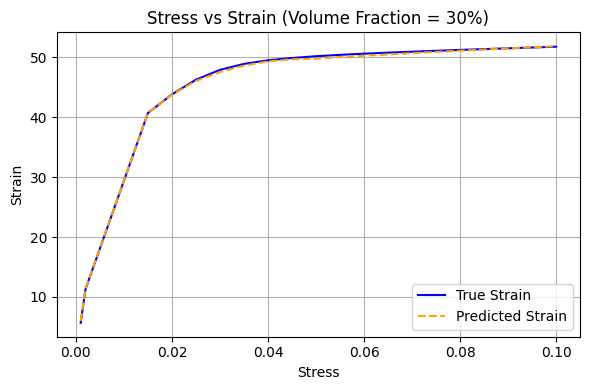

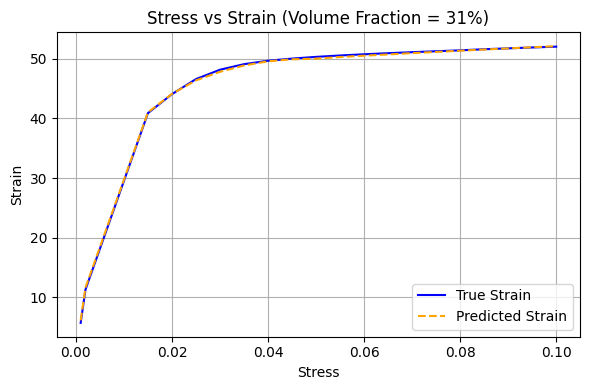

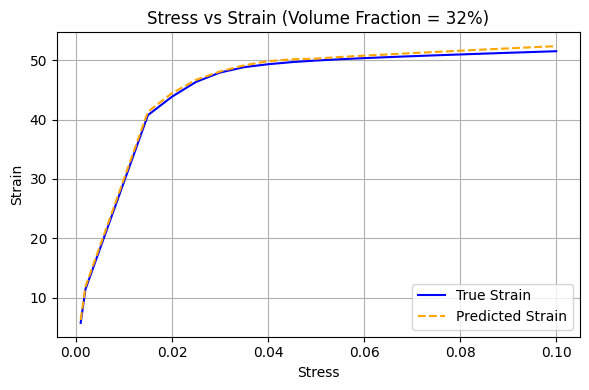

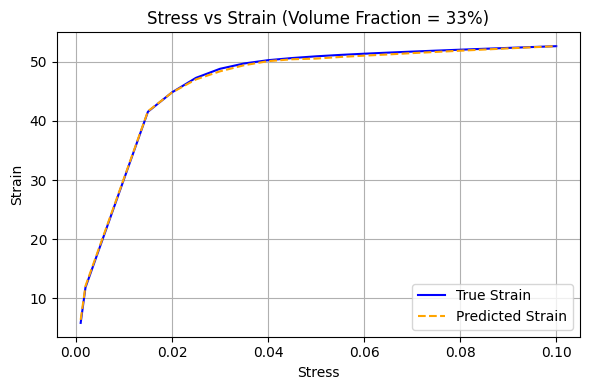

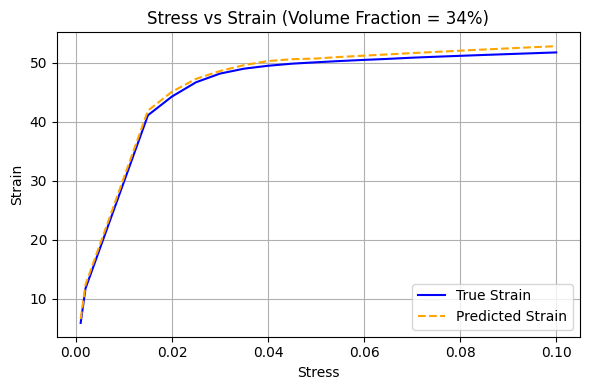

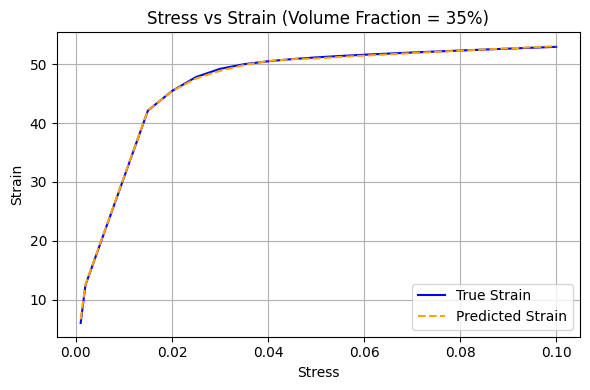

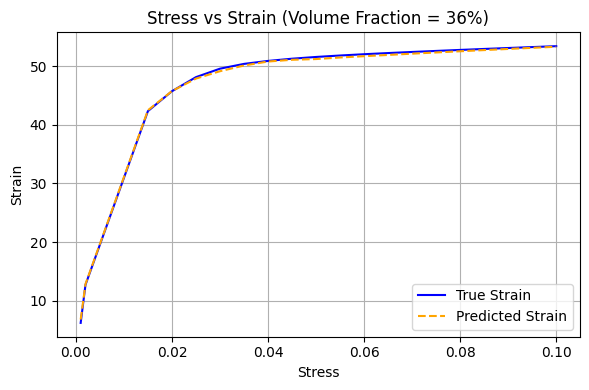

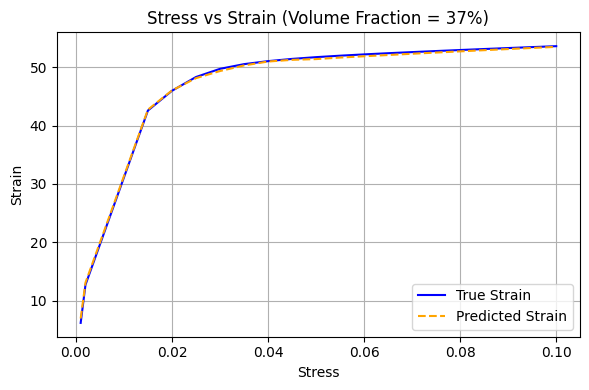

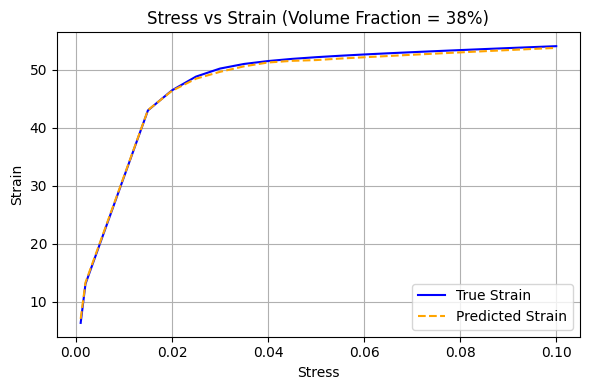

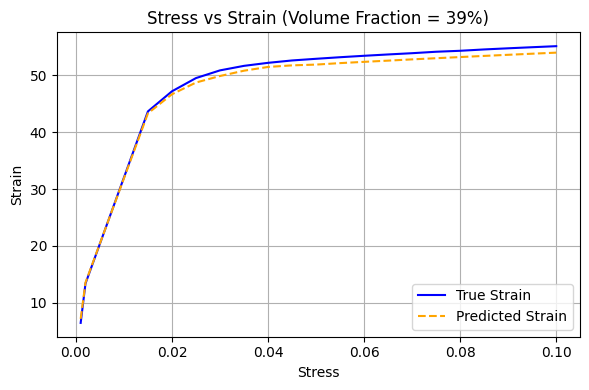

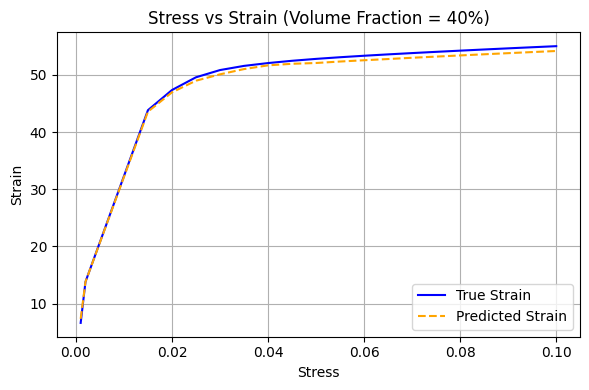

In [10]:
# 🔍 Set the model to evaluation mode (no gradients, dropout off)
model.eval()

# Get all unique volume fractions
unique_vf = sorted(df['Volume_Fraction'].unique())

# Loop through each volume fraction group
for vf in unique_vf:
    # Filter the data for the current volume fraction
    group = df[df['Volume_Fraction'] == vf]

    # Extract inputs and true strain
    x_group = group[['X1', 'X2']].values         # Normalized volume fraction and stress
    y_true = group[['Strain']].values            # Actual strain values (not scaled)
    stress = group['Stress'].values              # For x-axis in plot

    # Convert input to tensor and add batch dimension
    x_tensor = torch.tensor(x_group, dtype=torch.float32).unsqueeze(0).to(device)

    # Make predictions with the trained RNN
    with torch.no_grad():
        y_pred_scaled, _ = model(x_tensor)       # Output is still scaled
        y_pred_scaled = y_pred_scaled.squeeze(0).cpu().numpy()

    # Inverse scale the predicted strain to original units
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Plot true vs. predicted strain for this volume fraction
    plt.figure(figsize=(6, 4))
    plt.plot(stress, y_true, label='True Strain', color='blue')
    plt.plot(stress, y_pred, label='Predicted Strain', color='orange', linestyle='--')
    plt.xlabel("Stress")
    plt.ylabel("Strain")
    plt.title(f"Stress vs Strain (Volume Fraction = {vf}%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **Evaluate RNN Performance Using Error Metrics**

To quantitatively assess how well the RNN predicts strain, we compute:
- **Mean Squared Error (MSE)** — penalizes larger errors more
- **Mean Absolute Error (MAE)** — gives average absolute error
- **R² Score (Coefficient of Determination)** — measures how well the model explains the variance in true strain

We calculate these metrics separately for each volume fraction to evaluate the model's consistency across different material configurations.

In [11]:
# Initialize list to store metric results for each volume fraction
metrics = []

# Loop through each volume fraction group
for vf in unique_vf:
    # Extract input and true output for this group
    group = df[df['Volume_Fraction'] == vf]
    x_group = group[['X1', 'X2']].values        # Normalized inputs
    y_true = group[['Strain']].values           # Ground truth strain (original scale)

    # Convert to tensor and add batch dimension
    x_tensor = torch.tensor(x_group, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict using the trained model
    with torch.no_grad():
        y_pred_scaled, _ = model(x_tensor)
        y_pred_scaled = y_pred_scaled.squeeze(0).cpu().numpy()

    # Inverse scale predicted strain back to original values
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Compute error metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Append results
    metrics.append([vf, mse, mae, r2])

# Create DataFrame to organize results
metrics_df = pd.DataFrame(metrics, columns=['Volume_Fraction', 'MSE', 'MAE', 'R2_Score'])

# Display sorted by volume fraction
print("\nRNN Error Metrics by Volume Fraction:")
print(metrics_df.sort_values("Volume_Fraction"))


RNN Error Metrics by Volume Fraction:
    Volume_Fraction       MSE       MAE  R2_Score
0                10  5.961689  2.380461  0.959970
1                11  4.521295  2.073495  0.969520
2                12  4.020385  1.957175  0.972992
3                13  3.819021  1.908708  0.974606
4                14  2.966609  1.679901  0.980287
5                15  1.964017  1.363332  0.986884
6                16  1.877451  1.333601  0.987560
7                17  2.008993  1.379910  0.986872
8                18  0.949702  0.939863  0.993732
9                19  0.442336  0.624397  0.997067
10               20  0.503851  0.678599  0.996682
11               21  0.300636  0.508760  0.998030
12               22  0.322104  0.537316  0.997867
13               23  0.169450  0.374088  0.998878
14               24  0.109235  0.276968  0.999292
15               25  0.261453  0.479314  0.998311
16               26  0.023971  0.119414  0.999845
17               27  0.028388  0.147146  0.999818
18         

### **Why Are We Using a Feedforward Neural Network (FFNN)?**

While Recurrent Neural Networks (RNNs) are designed to handle **sequential data**, we also want to test a simpler, non-sequential baseline: the **Feedforward Neural Network (FFNN)**.

The FFNN assumes that each (volume fraction, stress) → strain data point is **independent**, without relying on the order or structure of the sequence. This helps us answer:

> **Does modeling the stress–strain data as a sequence (via RNN) really improve prediction accuracy?**

By comparing the FFNN and RNN results side by side — especially using metrics like **R² score** — we can understand whether the added complexity of an RNN is justified.

In [12]:
class FFNNModel(nn.Module):
    def __init__(self):
        super(FFNNModel, self).__init__()

        # Define the FFNN architecture using nn.Sequential
        self.network = nn.Sequential(
            nn.Linear(2, 64),   # First hidden layer: input is 2 features (volume_fraction, stress)
            nn.ReLU(),          # Non-linear activation
            nn.Linear(64, 64),  # Second hidden layer with 64 neurons
            nn.ReLU(),          # Another ReLU for non-linearity
            nn.Linear(64, 1)    # Output layer: predict strain (1 value)
        )

    def forward(self, x):
        # Forward pass: pass input through the network
        return self.network(x)

In [19]:
# Use the same scaled X and y from earlier
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)  # shape: [N, 2]
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).to(device)  # shape: [N, 1]

Starting FFNN training...

Epoch 000 | Loss: 0.590070
Epoch 010 | Loss: 0.238547
Epoch 020 | Loss: 0.063737
Epoch 030 | Loss: 0.056101
Epoch 040 | Loss: 0.045455
Epoch 050 | Loss: 0.039048
Epoch 060 | Loss: 0.036054
Epoch 070 | Loss: 0.032699
Epoch 080 | Loss: 0.030349
Epoch 090 | Loss: 0.028224

FFNN training complete!


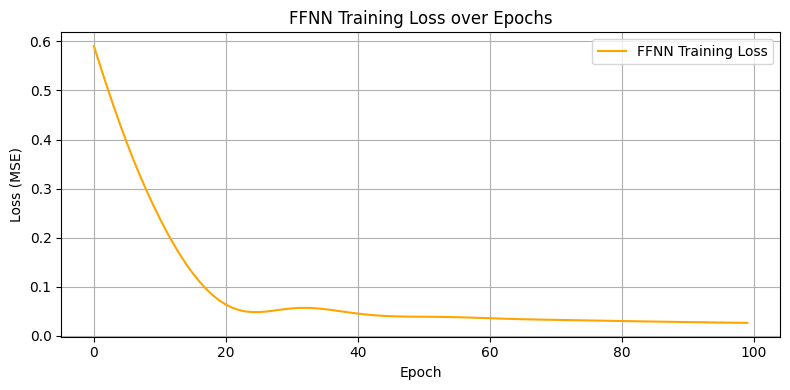

In [20]:
# Initialize model, loss, optimizer
ffnn = FFNNModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ffnn.parameters(), lr=0.001)

# Store loss values
ffnn_loss_history = []

# Training loop
print("Starting FFNN training...\n")
ffnn.train()
for epoch in range(100):
    optimizer.zero_grad()
    pred = ffnn(X_tensor)
    loss = criterion(pred, y_tensor)
    loss.backward()
    optimizer.step()

    # Save loss
    ffnn_loss_history.append(loss.item())

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.6f}")

print("\nFFNN training complete!")

# Plot FFNN loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(ffnn_loss_history, label="FFNN Training Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("FFNN Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

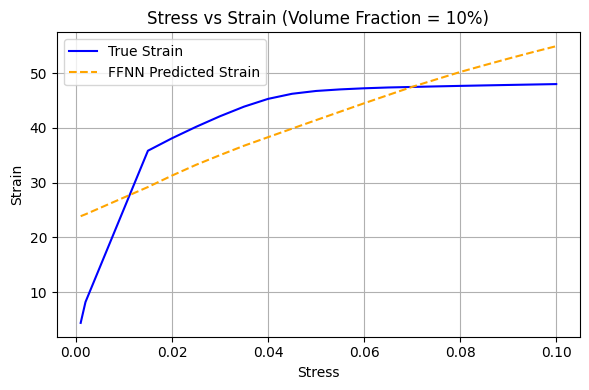

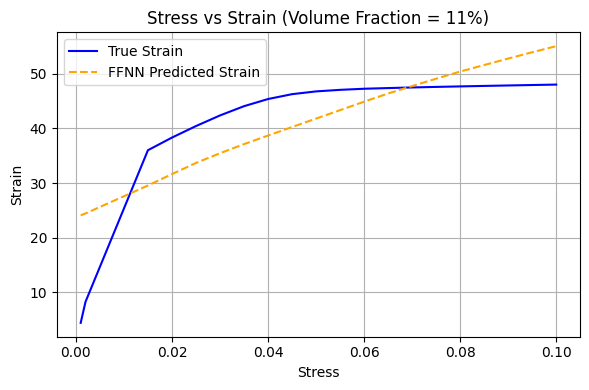

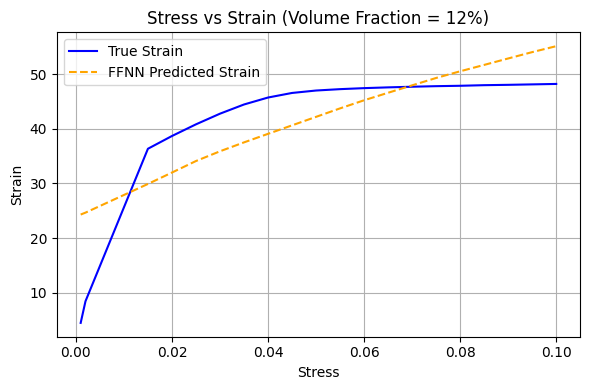

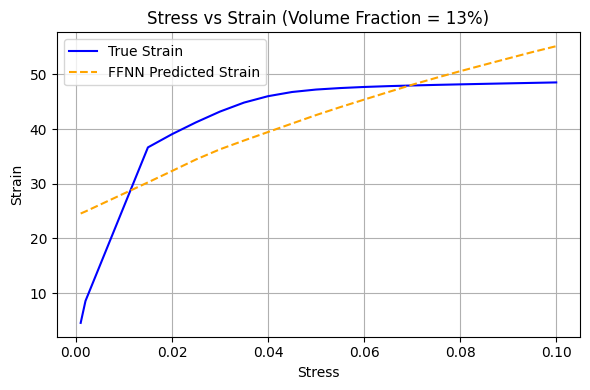

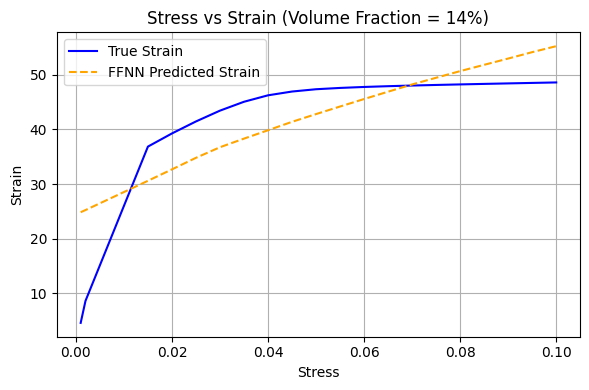

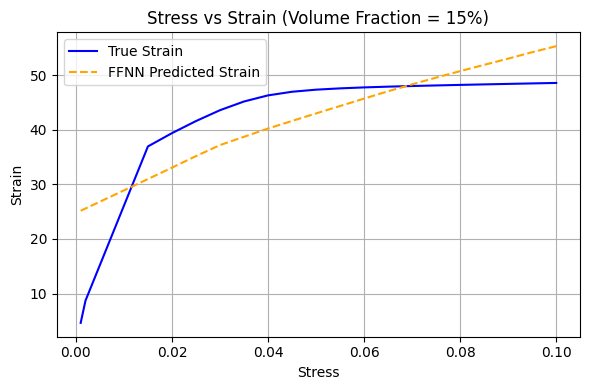

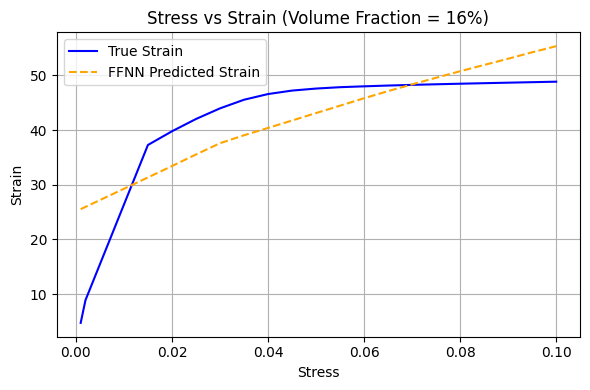

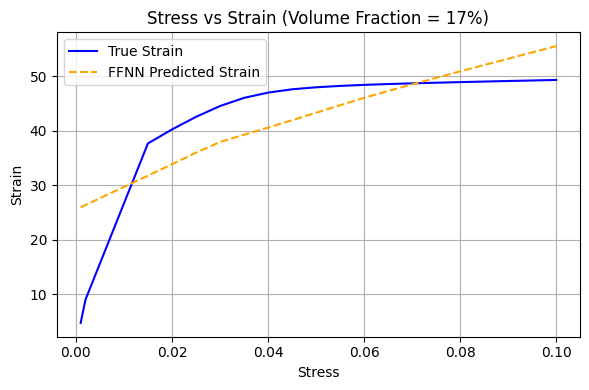

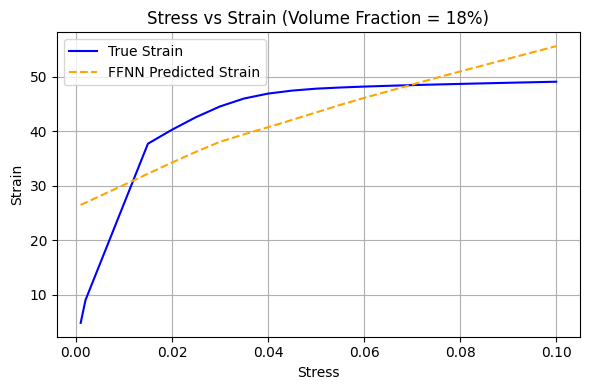

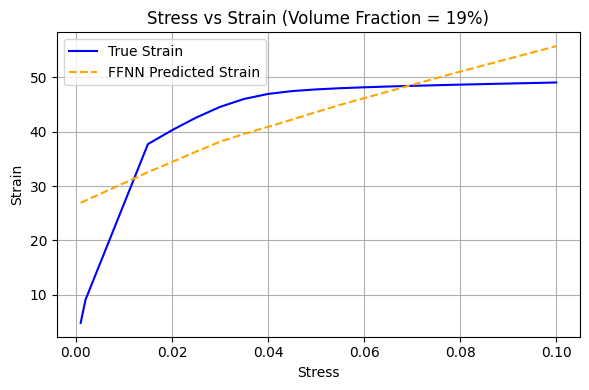

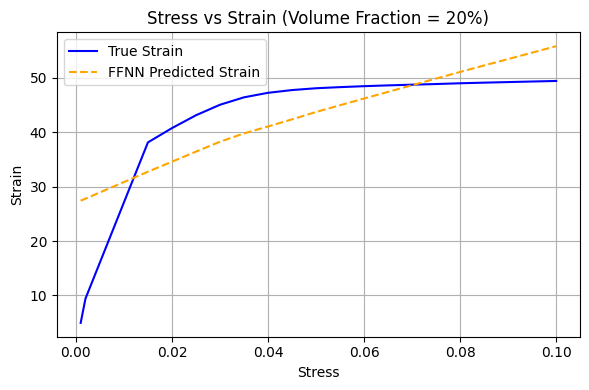

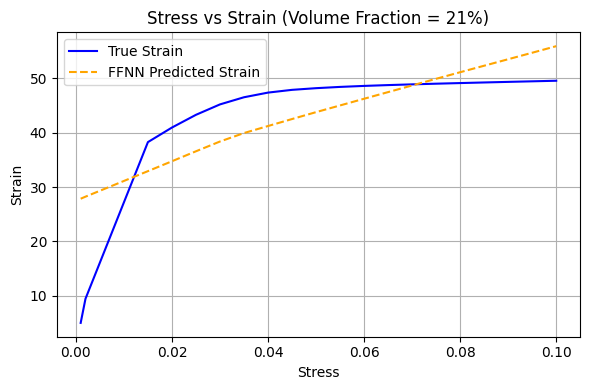

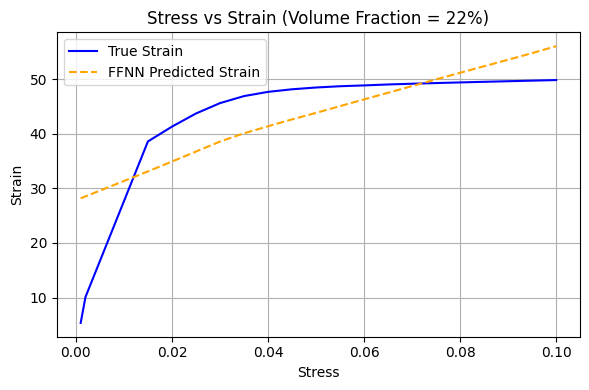

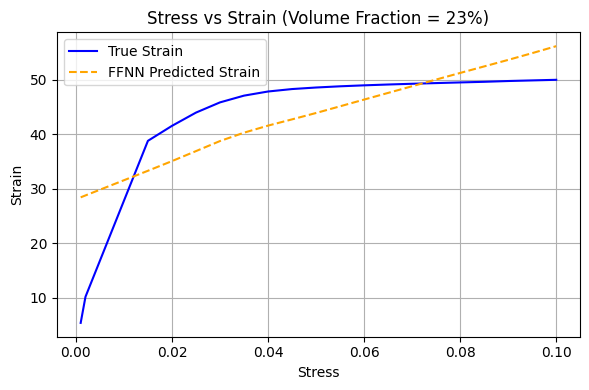

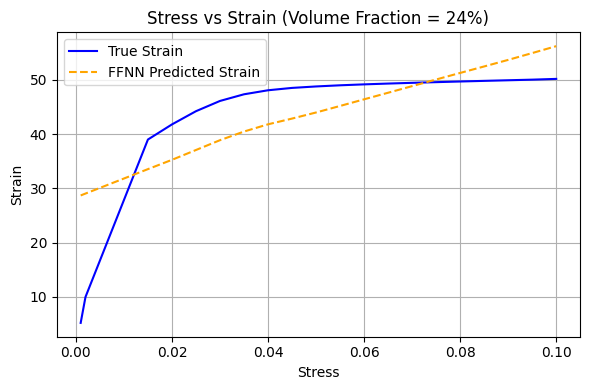

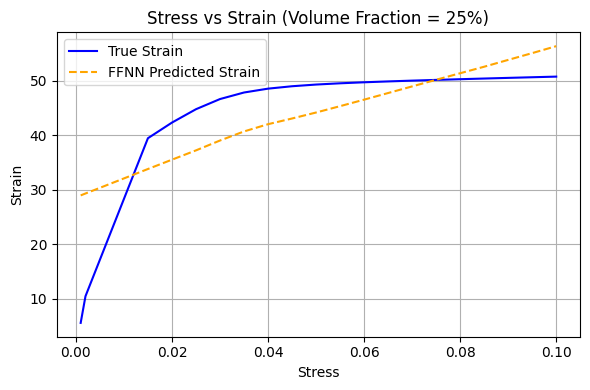

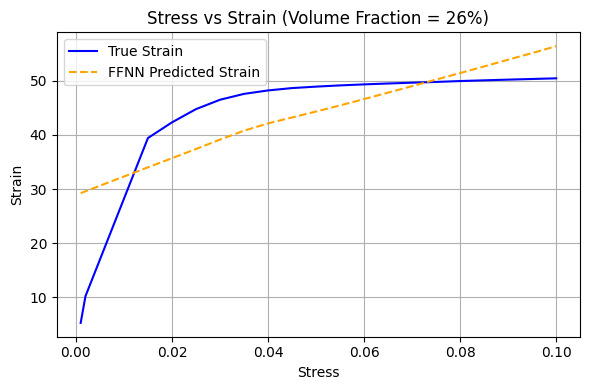

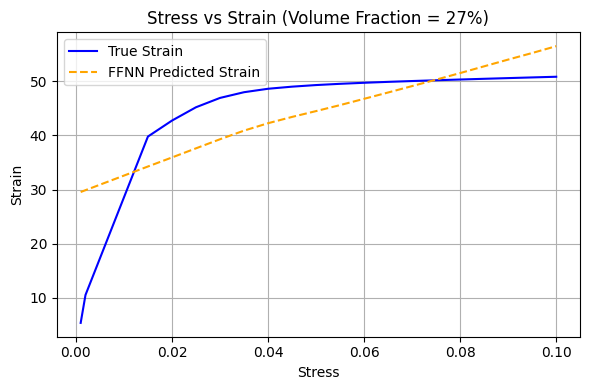

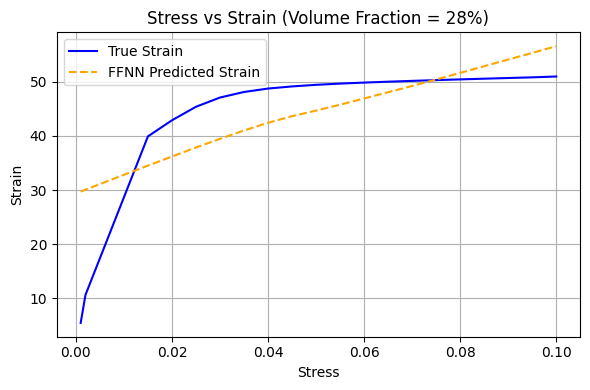

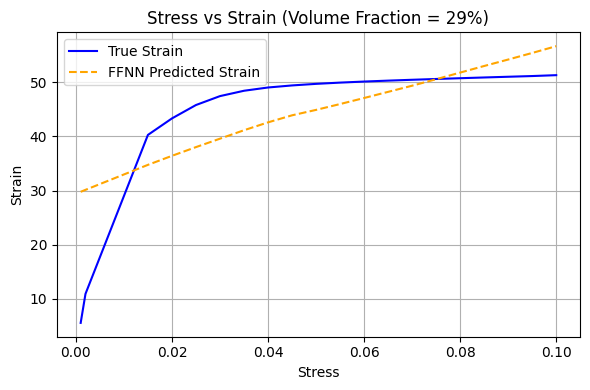

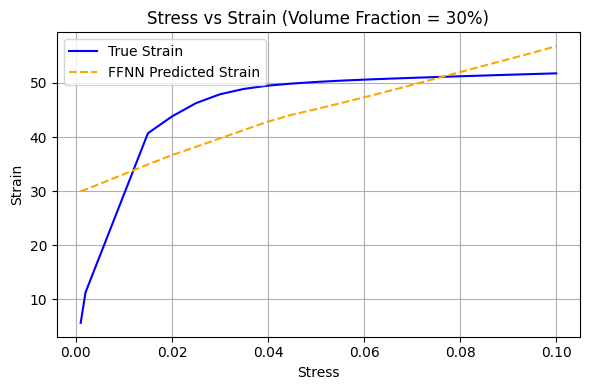

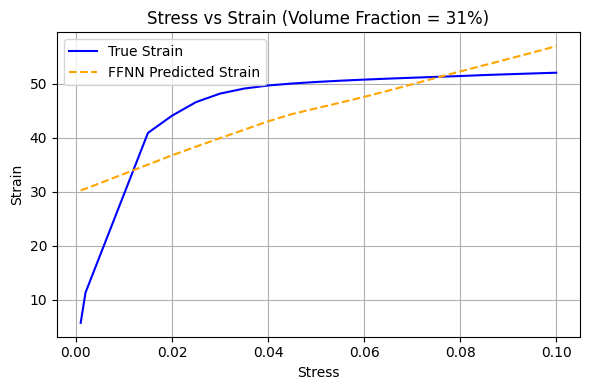

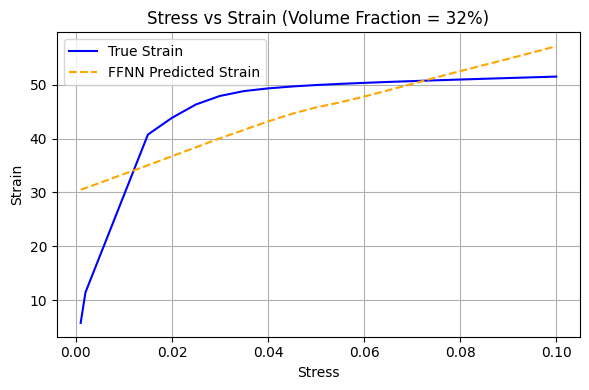

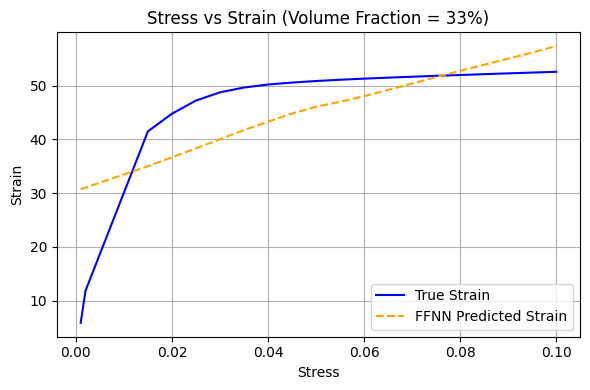

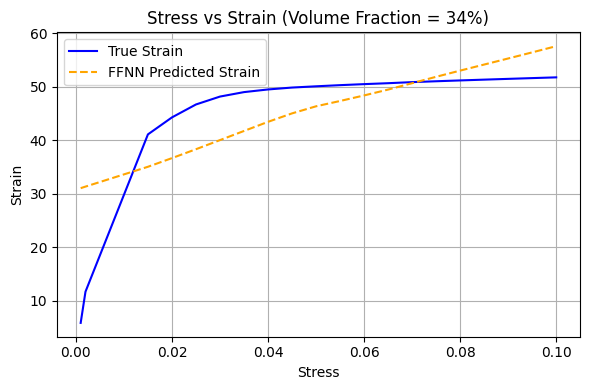

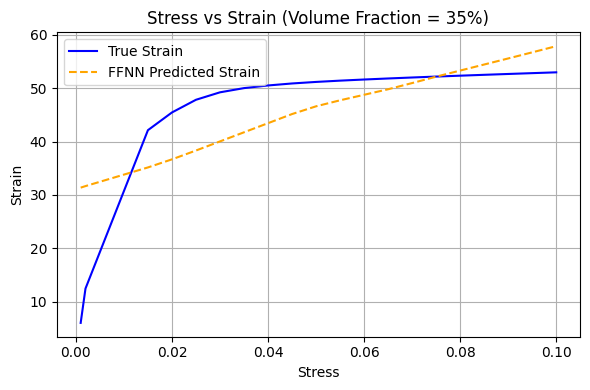

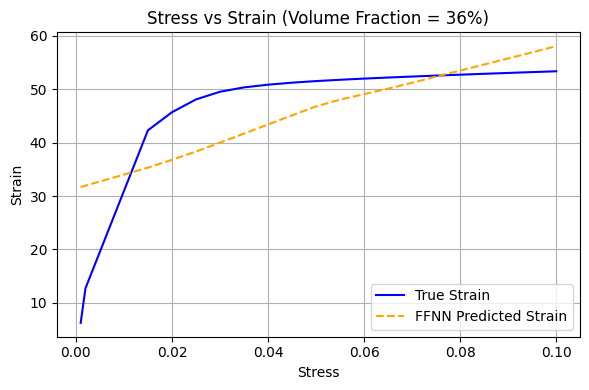

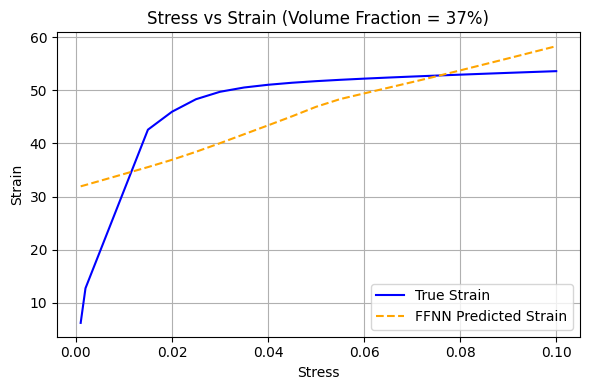

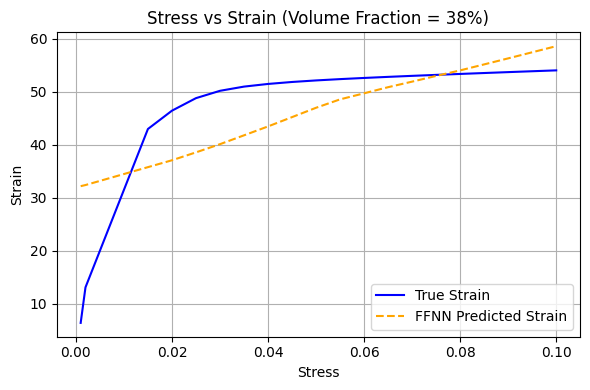

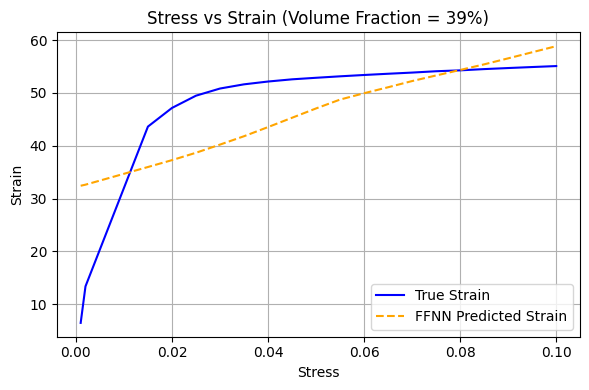

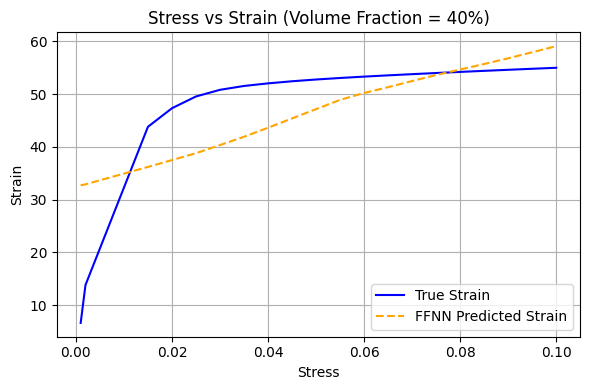

In [21]:
# Grouped plot: Stress vs Strain for each volume fraction
unique_vf = sorted(df['Volume_Fraction'].unique())

ffnn.eval()
for vf in unique_vf:
    group = df[df['Volume_Fraction'] == vf]

    # Get normalized input
    X_group = scaler_x.transform(group[['Volume_Fraction', 'Stress']].values)
    y_true = group[['Strain']].values
    stress = group['Stress'].values

    X_tensor = torch.tensor(X_group, dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_scaled = ffnn(X_tensor).cpu().numpy()

    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Plot stress vs strain
    plt.figure(figsize=(6, 4))
    plt.plot(stress, y_true, label='True Strain', color='blue')
    plt.plot(stress, y_pred, label='FFNN Predicted Strain', color='orange', linestyle='--')
    plt.xlabel("Stress")
    plt.ylabel("Strain")
    plt.title(f"Stress vs Strain (Volume Fraction = {vf}%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
metrics_ffnn = []

for vf in sorted(df['Volume_Fraction'].unique()):
    group = df[df['Volume_Fraction'] == vf]

    # Get normalized input
    X_group = scaler_x.transform(group[['Volume_Fraction', 'Stress']].values)
    y_true = group[['Strain']].values

    X_tensor = torch.tensor(X_group, dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_scaled = ffnn(X_tensor).cpu().numpy()

    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics_ffnn.append([vf, mse, mae, r2])

# Display results
metrics_ffnn_df = pd.DataFrame(metrics_ffnn, columns=["Volume_Fraction", "MSE", "MAE", "R2_Score"])
print("\nFFNN Error Metrics by Volume Fraction:")
print(metrics_ffnn_df.sort_values("Volume_Fraction"))


FFNN Error Metrics by Volume Fraction:
    Volume_Fraction        MSE       MAE  R2_Score
0                10  57.479094  6.112319  0.614054
1                11  56.809881  6.027799  0.617022
2                12  56.586965  5.976424  0.619864
3                13  56.490604  5.909720  0.624381
4                14  56.482582  5.858429  0.624670
5                15  56.250313  5.785642  0.624357
6                16  57.017801  5.779052  0.622214
7                17  58.379466  5.808552  0.618523
8                18  59.585095  5.799946  0.606764
9                19  60.664213  5.798042  0.597774
10               20  62.501189  5.875708  0.588383
11               21  64.132625  5.915122  0.579721
12               22  64.115954  5.955730  0.575486
13               23  64.831215  5.973076  0.570865
14               24  67.177486  6.042780  0.564695
15               25  67.419275  6.080311  0.564558
16               26  68.386442  6.027040  0.556714
17               27  69.750583  6.092922  

### **R² Score Comparison: RNN vs FFNN**

To evaluate which model performs better at predicting strain from stress and volume fraction, we compare the **R² scores** (coefficient of determination) for each model across all volume fractions.

- **RNN** captures sequence dependencies within each stress–strain curve (treated as a time series).
- **FFNN** treats each (volume fraction, stress) input as independent, without considering sequential structure.

By plotting the R² scores side-by-side for each volume fraction, we can visually assess:
- Which model generalizes better?
- Does sequence modeling via RNN lead to better accuracy?

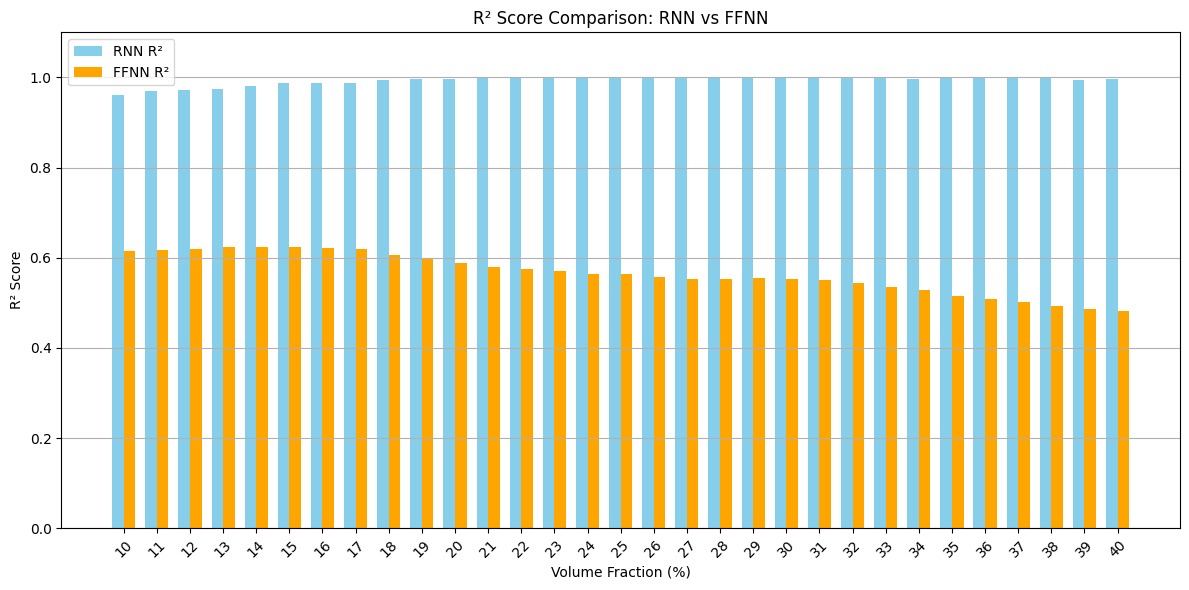

In [23]:
# Ensure both are sorted by Volume_Fraction
metrics_rnn_sorted = metrics_df.sort_values("Volume_Fraction").reset_index(drop=True)
metrics_ffnn_sorted = metrics_ffnn_df.sort_values("Volume_Fraction").reset_index(drop=True)

# Merge the two R² columns into one DataFrame
r2_comparison = pd.DataFrame({
    "Volume_Fraction": metrics_rnn_sorted["Volume_Fraction"],
    "RNN_R2": metrics_rnn_sorted["R2_Score"],
    "FFNN_R2": metrics_ffnn_sorted["R2_Score"]
})

import matplotlib.pyplot as plt
import numpy as np

volume_fractions = r2_comparison["Volume_Fraction"]
r2_rnn = r2_comparison["RNN_R2"]
r2_ffnn = r2_comparison["FFNN_R2"]

x = np.arange(len(volume_fractions))  # label locations
width = 0.35  # bar width

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, r2_rnn, width, label='RNN R²', color='skyblue')
plt.bar(x + width/2, r2_ffnn, width, label='FFNN R²', color='orange')

plt.xlabel("Volume Fraction (%)")
plt.ylabel("R² Score")
plt.title("R² Score Comparison: RNN vs FFNN")
plt.xticks(ticks=x, labels=volume_fractions.astype(int), rotation=45)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()